In [143]:
from google.colab import drive
%pip install ipython-sql sqlalchemy
%load_ext sql
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [144]:
engine = create_engine('sqlite://')

id_url = '1MddNYnMBinkl8YGlPC4jb3i-kdmGBdu8'
url_csv = f'https://drive.google.com/uc?export=download&id={id_url}'
df = pd.read_csv(url_csv)
df.to_sql('warehouse', con=engine, if_exists='replace', index=False)

%sql sqlite://

query_table = """ SELECT * 
FROM warehouse"""

result_table = pd.read_sql_query(query_table, engine)
print(result_table.head())

   YEAR  MONTH                           SUPPLIER ITEM CODE  \
0  2020      1  REPUBLIC NATIONAL DISTRIBUTING CO    100009   
1  2020      1                          PWSWN INC    100024   
2  2020      1            RELIABLE CHURCHILL LLLP      1001   
3  2020      1          LANTERNA DISTRIBUTORS INC    100145   
4  2020      1               DIONYSOS IMPORTS INC    100293   

                      ITEM DESCRIPTION ITEM TYPE  RETAIL SALES  \
0                  BOOTLEG RED - 750ML      WINE          0.00   
1            MOMENT DE PLAISIR - 750ML      WINE          0.00   
2  S SMITH ORGANIC PEAR CIDER - 18.7OZ      BEER          0.00   
3        SCHLINK HAUS KABINETT - 750ML      WINE          0.00   
4       SANTORINI GAVALA WHITE - 750ML      WINE          0.82   

   RETAIL TRANSFERS  WAREHOUSE SALES  
0               0.0              2.0  
1               1.0              4.0  
2               0.0              1.0  
3               0.0              1.0  
4               0.0          

1. **Eksplorasi Struktur Data:** Berapa jumlah total baris dan kolom dalam dataset ini? Tampilkan tipe data untuk setiap kolom.
2. **Pembersihan Data (Data Cleaning):** Periksa apakah ada nilai yang hilang (*missing values*) di seluruh kolom. Jika ada, sebutkan kolom mana saja dan berapa jumlah nilai yang hilang tersebut.
3. **Analisis Frekuensi:** Kategori produk (`ITEM TYPE`) manakah yang paling sering muncul dalam dataset ini? Berikan 5 kategori teratas.
4. **Agregasi Penjualan Ritel:** Hitung total `RETAIL SALES` berdasarkan `ITEM TYPE`. Kategori manakah yang menghasilkan total penjualan ritel tertinggi?
5. **Performa Supplier:** Siapakah 10 `SUPPLIER` dengan total `WAREHOUSE SALES` paling banyak?
6. **Analisis Statistik Deskriptif:** Khusus untuk produk dengan `ITEM TYPE` berupa "BEER", hitunglah nilai rata-rata (*mean*), median, dan standar deviasi dari `RETAIL SALES`.
7. **Tren Bulanan:** Berdasarkan data tahun 2020, pada bulan keberapa total `RETAIL SALES` mencapai puncaknya?
8. **Analisis Hubungan (Korelasi):** Hitunglah koefisien korelasi antara `RETAIL SALES` dan `WAREHOUSE SALES`. Jelaskan secara singkat apakah terdapat hubungan yang kuat antara keduanya berdasarkan hasil perhitungan tersebut.
9. **Filter Data Spesifik:** Identifikasi semua item dari supplier `REPUBLIC NATIONAL DISTRIBUTING CO`. Berapa banyak kode item unik (`ITEM CODE`) yang didistribusikan oleh supplier ini?
10. **Rekayasa Fitur (*Feature Engineering*):** Buatlah kolom baru bernama `TOTAL_SALES` yang merupakan hasil penjumlahan dari `RETAIL SALES` dan `WAREHOUSE SALES`. Kemudian, temukan 3 produk unik (`ITEM DESCRIPTION`) dengan `TOTAL_SALES` tertinggi di seluruh dataset.

In [145]:
# total kolom dan baris beserta data type
df.info()

# cek missing value
print(df.isnull().sum())

# print baris missing value
print(df[df.isnull().any(axis=1)])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM CODE         307645 non-null  object 
 4   ITEM DESCRIPTION  307645 non-null  object 
 5   ITEM TYPE         307644 non-null  object 
 6   RETAIL SALES      307642 non-null  float64
 7   RETAIL TRANSFERS  307645 non-null  float64
 8   WAREHOUSE SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB
YEAR                  0
MONTH                 0
SUPPLIER            167
ITEM CODE             0
ITEM DESCRIPTION      0
ITEM TYPE             1
RETAIL SALES          3
RETAIL TRANSFERS      0
WAREHOUSE SALES       0
dtype: int64
        YEAR  MONTH SUPPLIER ITEM CODE           ITEM DESCRIPTION  \
1

Pertama mengenai missing value di supplier itu ketika dicheck datanya benar hilang jadi cara menanganinya mungkin ada 2 cara yaitu dengan mengisi dummy di missing value tersebut atau menghapus baris data tersebut. Saya akan memakai mengisi dengan dummy di suppliernya.

In [146]:
# mengatasi missing value di kolom supplier dengan "Unknown"
df['SUPPLIER'] = df['SUPPLIER'].fillna('Unknown')

# isi missing value exact baris dengan WINE
df.at[95673, 'ITEM TYPE'] = 'WINE'

# isi missing value di RETAIL SALES dengan 0
df['RETAIL SALES'] = df['RETAIL SALES'].fillna(0)

# verifikasi tidak ada missing value lagi
print(df.isnull().sum())

YEAR                0
MONTH               0
SUPPLIER            0
ITEM CODE           0
ITEM DESCRIPTION    0
ITEM TYPE           0
RETAIL SALES        0
RETAIL TRANSFERS    0
WAREHOUSE SALES     0
dtype: int64


     ITEM TYPE  frequency
0         WINE     187640
1       LIQUOR      64910
2         BEER      42413
3         KEGS      10146
4  NON-ALCOHOL       1908


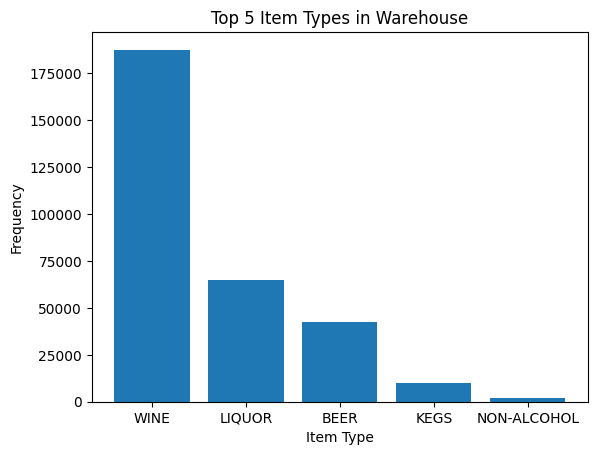

In [147]:
# top 5 item type yang sering muncul dengan sql
query_item_type = """ SELECT "ITEM TYPE", COUNT(*) as frequency
FROM warehouse
GROUP BY "ITEM TYPE"
ORDER BY frequency DESC
LIMIT 5"""

result_item_type = pd.read_sql_query(query_item_type, engine)
print(result_item_type)

# visualisasi top 5 item type
plt.bar(result_item_type['ITEM TYPE'], result_item_type['frequency'])
plt.xlabel('Item Type')
plt.ylabel('Frequency')
plt.title('Top 5 Item Types in Warehouse')
plt.show()

      ITEM TYPE  total_retail_sales
0        LIQUOR           802691.43
1          WINE           746498.59
2          BEER           574220.53
3   NON-ALCOHOL            34084.31
4  STR_SUPPLIES             2740.88
5           REF              663.63


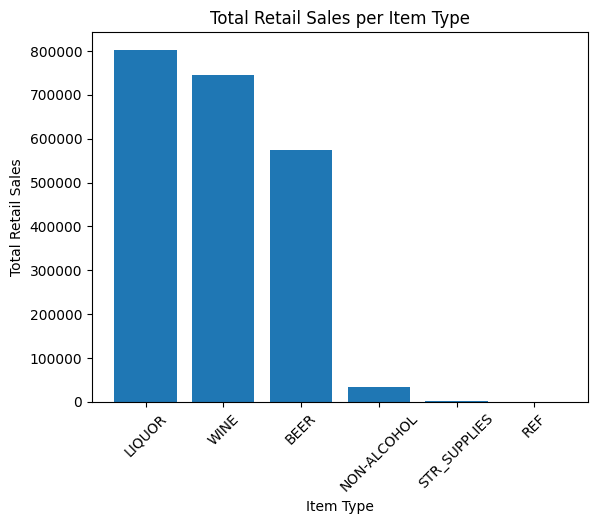

In [148]:
# hitung total retail sales per item type dengan 
query_retail_sales = """SELECT "ITEM TYPE", SUM("RETAIL SALES") as total_retail_sales
FROM warehouse
GROUP BY "ITEM TYPE"
ORDER BY total_retail_sales DESC
LIMIT 6"""

result_retail_sales = pd.read_sql_query(query_retail_sales, engine)
print(result_retail_sales)

# visualisasi total retail sales per item type
plt.bar(result_retail_sales['ITEM TYPE'], result_retail_sales['total_retail_sales'])
plt.xlabel('Item Type')
plt.ylabel('Total Retail Sales')
plt.title('Total Retail Sales per Item Type')
plt.xticks(rotation=45)
plt.show()

                   SUPPLIER  total_warehouse_sales
0             CROWN IMPORTS             1651871.51
1    MILLER BREWING COMPANY             1425428.71
2        ANHEUSER BUSCH INC             1331170.84
3              HEINEKEN USA              829796.46
4        E & J GALLO WINERY              197463.78
5   BOSTON BEER CORPORATION              191592.89
6  DIAGEO NORTH AMERICA INC              170564.63
7         YUENGLING BREWERY              134147.86
8   FLYING DOG BREWERY LLLP              128292.49
9      CONSTELLATION BRANDS              119399.51


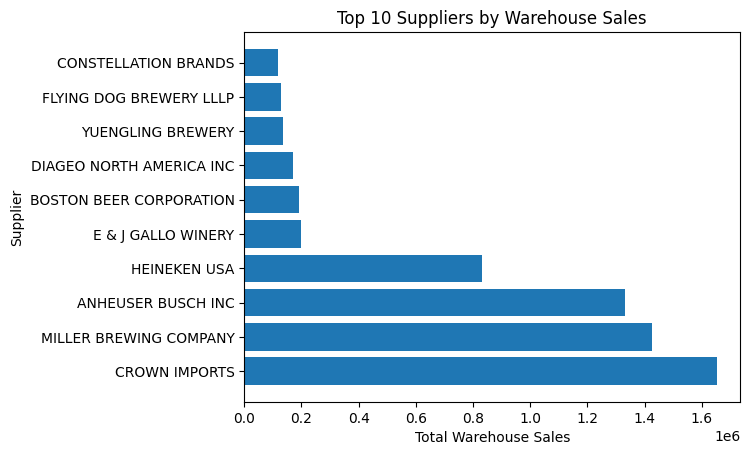

In [149]:
# top 10 SUPPLIER berdasarkan WAREHOUSE SALES
query_supplier_sales = """ SELECT SUPPLIER, SUM("WAREHOUSE SALES") as total_warehouse_sales
FROM warehouse
GROUP BY SUPPLIER
ORDER BY total_warehouse_sales DESC
LIMIT 10"""

result_supplier_sales = pd.read_sql_query(query_supplier_sales, engine)
print(result_supplier_sales)

# visualisasi top 10 supplier berdasarkan warehouse sales
plt.barh(result_supplier_sales['SUPPLIER'], result_supplier_sales['total_warehouse_sales'])
plt.xlabel('Total Warehouse Sales')
plt.ylabel('Supplier')
plt.title('Top 10 Suppliers by Warehouse Sales')
plt.show()

In [150]:
# ITEM TYPE Beer hitung mean, median, dan standar deviasi dari RETAIL SALES
beer_sales = df[df['ITEM TYPE'] == 'BEER']['RETAIL SALES']
mean_beer_sales = beer_sales.mean()
median_beer_sales = beer_sales.median()
std_beer_sales = beer_sales.std()

print(f"Mean Retail Sales for BEER: {mean_beer_sales}")
print(f"Median Retail Sales for BEER: {median_beer_sales}")
print(f"Standard Deviation of Retail Sales for BEER: {std_beer_sales}")

Mean Retail Sales for BEER: 13.538785985428996
Median Retail Sales for BEER: 0.0
Standard Deviation of Retail Sales for BEER: 57.506939825119154


   MONTH  total_retail_sales
0      1            74318.77
1      3           109411.29
2      7            94538.96
3      9            82108.68


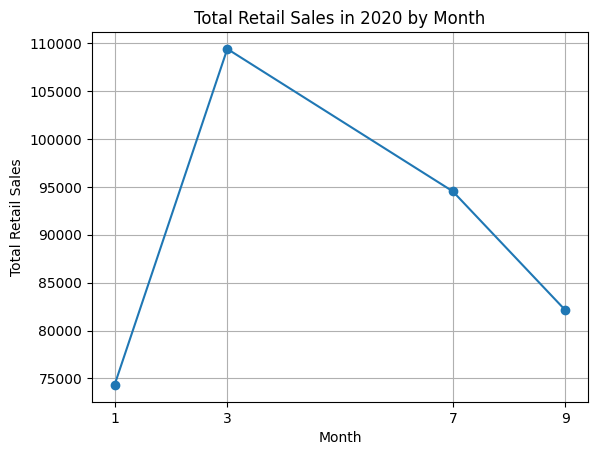

In [151]:
# total retail sales tahun 2020 bulan ke bulan gunakan kolom MONTH
query_monthly_sales_2020 = """ SELECT MONTH, SUM("RETAIL SALES") as total_retail_sales
FROM warehouse
WHERE YEAR = 2020
GROUP BY MONTH
ORDER BY MONTH"""

result_monthly_sales_2020 = pd.read_sql_query(query_monthly_sales_2020, engine)
print(result_monthly_sales_2020)

# visualisasi total retail sales tahun 2020 bulan ke bulan
plt.plot(result_monthly_sales_2020['MONTH'], result_monthly_sales_2020['total_retail_sales'], marker='o')
plt.xlabel('Month')
plt.ylabel('Total Retail Sales')
plt.title('Total Retail Sales in 2020 by Month')
plt.xticks(result_monthly_sales_2020['MONTH'])
plt.grid()
plt.show()


In [152]:
# Koefisien korelasi antara RETAIL SALES dan WAREHOUSE SALES
correlation = df['RETAIL SALES'].corr(df['WAREHOUSE SALES'])
print(f"Correlation between RETAIL SALES and WAREHOUSE SALES: {correlation}")

Correlation between RETAIL SALES and WAREHOUSE SALES: 0.490472181458158


Berdasarkan hasil dari koefisien korelasi adanya hubungan positif antara kolom RETAIL SALES dan WAREHOUSE SALES
karena nilai menunjukan 0.49

In [153]:
# cari item kode unik REPUBLIC NATIONAL DISTRIBUTING CO
query_republic_national = """ SELECT DISTINCT "ITEM CODE"
FROM warehouse
WHERE SUPPLIER = 'REPUBLIC NATIONAL DISTRIBUTING CO'
"""

result_republic_national = pd.read_sql_query(query_republic_national, engine)
print(result_republic_national)

     ITEM CODE
0       100009
1       101702
2        10693
3        10898
4       109053
...        ...
2523    385450
2524    385468
2525    406120
2526    408778
2527     66001

[2528 rows x 1 columns]


In [154]:
# buat kolom baru TOTAL SALES sebagai penjumlahan RETAIL SALES dan WAREHOUSE SALES
query_total_sales = """ SELECT *, ("RETAIL SALES" + "WAREHOUSE SALES") as "TOTAL SALES"
FROM warehouse
"""

result_total_sales = pd.read_sql_query(query_total_sales, engine)
print(result_total_sales.head())

   YEAR  MONTH                           SUPPLIER ITEM CODE  \
0  2020      1  REPUBLIC NATIONAL DISTRIBUTING CO    100009   
1  2020      1                          PWSWN INC    100024   
2  2020      1            RELIABLE CHURCHILL LLLP      1001   
3  2020      1          LANTERNA DISTRIBUTORS INC    100145   
4  2020      1               DIONYSOS IMPORTS INC    100293   

                      ITEM DESCRIPTION ITEM TYPE  RETAIL SALES  \
0                  BOOTLEG RED - 750ML      WINE          0.00   
1            MOMENT DE PLAISIR - 750ML      WINE          0.00   
2  S SMITH ORGANIC PEAR CIDER - 18.7OZ      BEER          0.00   
3        SCHLINK HAUS KABINETT - 750ML      WINE          0.00   
4       SANTORINI GAVALA WHITE - 750ML      WINE          0.82   

   RETAIL TRANSFERS  WAREHOUSE SALES  TOTAL SALES  
0               0.0              2.0         2.00  
1               1.0              4.0         4.00  
2               0.0              1.0         1.00  
3               

In [155]:
# 3 produk unik dengan total sales tertinggi
query_top_total_sales = """ SELECT "ITEM DESCRIPTION", SUM("RETAIL SALES" + "WAREHOUSE SALES") as total_sales
FROM warehouse
GROUP BY "ITEM DESCRIPTION"
ORDER BY total_sales DESC
LIMIT 3"""

result_top_total_sales = pd.read_sql_query(query_top_total_sales, engine)
print(result_top_total_sales)

               ITEM DESCRIPTION  total_sales
0  CORONA EXTRA LOOSE NR - 12OZ    328224.83
1   CORONA EXTRA 2/12 NR - 12OZ    257679.62
2      HEINEKEN LOOSE NR - 12OZ    189711.21


**INSIGHT DATA**

Dataset ini menunjukkan dominasi yang sangat kuat dari kategori Wine yang muncul sebanyak 187.640 kali, jauh melampaui kategori lainnya seperti Liquor dan Beer. Namun, menariknya, frekuensi kemunculan tidak selalu berbanding lurus dengan nilai uang yang dihasilkan. Meskipun Wine paling sering muncul, kategori Liquor menjadi penghasil keuntungan tertinggi di kanal ritel dengan total penjualan mencapai 802.691,43, disusul oleh Wine dan Beer. Hal ini mengindikasikan bahwa meskipun stok varian Wine sangat banyak, Liquor memiliki nilai transaksi atau volume penjualan per unit yang lebih tinggi di mata konsumen ritel.

Dari sisi distribusi besar (warehouse), Crown Imports muncul sebagai pemain utama dengan total penjualan gudang mencapai 1.651.871,51, diikuti oleh raksasa produsen bir lainnya seperti Miller Brewing Company dan Anheuser Busch Inc. Ketergantungan terhadap supplier tertentu juga terlihat pada Republic National Distributing Co, yang mendistribusikan setidaknya 2.528 kode item unik dalam sistem ini.

Melihat tren sepanjang tahun 2020, aktivitas belanja ritel mengalami fluktuasi yang cukup dinamis. Penjualan mencapai puncaknya pada bulan ke-3 (Maret) dengan total penjualan ritel sebesar 109.411,29, sebelum akhirnya melandai dan kembali naik tipis di bulan Juli. Di sisi lain, analisis korelasi menunjukkan angka 0,49 antara penjualan ritel dan penjualan gudang. Angka ini menunjukkan adanya hubungan positif yang moderat; artinya, ketika permintaan di toko ritel meningkat, pengiriman dari gudang cenderung ikut meningkat, namun tidak selalu dalam proporsi yang sama persis karena mungkin dipengaruhi oleh stok cadangan atau distribusi ke kanal non-ritel.

Secara spesifik, produk yang menjadi "bintang" dalam dataset ini adalah Corona Extra, di mana varian Loose NR dan 2/12 NR menempati posisi teratas dengan total penjualan gabungan (ritel + gudang) yang sangat masif, disusul oleh Heineken. Namun, jika melihat statistik khusus untuk kategori Beer, terdapat anomali yang cukup menarik: nilai rata-rata penjualan ritelnya adalah 13,53, tetapi nilai mediannya berada di angka 0,0. Hal ini memberikan insight bahwa banyak stok bir yang tercatat di sistem sebenarnya tidak terjual secara ritel (mungkin lebih banyak bergerak di transfer stok atau penjualan grosir), sementara sebagian kecil produk lainnya terjual dalam jumlah yang sangat besar sehingga mendongkrak nilai rata-rata.